In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython import display
import os

In [0]:
tf.enable_eager_execution()

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
BUFFER_SIZE = x_train.shape[0]
train_num = int(np.floor(x_train.shape[0]/128)*128)
BATCH_SIZE = 128

x = ((x_train.astype("float32")-127.5)/127.5).reshape(60000,28,28,1)
y = y_train.reshape(-1, 1) # y_train.shape : (60000,) --> (60000,1) 

In [0]:
train_data_x = tf.data.Dataset.from_tensor_slices(x[:train_num]).batch(BATCH_SIZE)
train_data_y = tf.data.Dataset.from_tensor_slices(y[:train_num]).batch(BATCH_SIZE)
numbers_to_generate = 100
noise_dim = 100

In [0]:
path = 'train_figs'
if not os.path.isdir(path):
    os.mkdir(path)

# Generator

In [0]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, ReLU, LeakyReLU, Conv2DTranspose, Flatten, concatenate, Embedding, Conv2D, Dropout
from tensorflow.keras.initializers import RandomNormal

In [0]:
def generator():
    
    noise = Input(shape=(noise_dim,), name = 'noise')
    label = Input(shape=(10,), name = 'label') # 10 categories
    
    input1 = Reshape((7,7,128))(Dense(7*7*128, use_bias=False, kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(noise))
    input2 = Reshape((7,7,1))(Dense(49, use_bias=False, kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(Embedding(10, 100)(label)))
    
    h1 = ReLU()(BatchNormalization()(concatenate([input1, input2])))
    
    h2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h1)
    h_2 = ReLU()(BatchNormalization()(h2))
    
    h3 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h_2)
    h_3 = ReLU()(BatchNormalization()(h3))
    
    h4 = Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h_3)
    h_4 = ReLU()(BatchNormalization()(h4))
    
    gen_pics = Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='tanh', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h_4)    
    
    return Model(inputs=[noise, label], outputs=gen_pics)

In [0]:
gen = generator()

In [10]:
gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 100)      1000        label[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         627200      noise[0][0]                      
______________________________________________________________________________________________

# Discriminator

In [0]:
def discriminator():
    
    pic = Input(shape=(28, 28, 1), name='picture') # input1
    pic_label = Input(shape=(10,), name='label')
    input2=Reshape((28,28,1))(Dense(28*28, use_bias=False, kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(Embedding(10, 100)(pic_label)))
    
    conv_1 = Conv2D(32, (5,5), strides=(2,2), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(concatenate([pic, input2]))
    h1 = LeakyReLU(0.2)(conv_1)

    conv_2 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h1)    
    h2 = LeakyReLU(0.2)(BatchNormalization()(conv_2))

    conv_3 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h2)    
    h3 = LeakyReLU(0.2)(BatchNormalization()(conv_3))

    output = Dense(1, activation='sigmoid')(Flatten()(h3))
    
    return Model(inputs=[pic, pic_label], outputs=output)

In [0]:
dis = discriminator()

In [13]:
dis.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 100)      1000        label[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10, 784)      78400       embedding_1[0][0]                
__________________________________________________________________________________________________
picture (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

# Loss function

In [0]:
def G_loss(fake_pics):
    # labels = 1, try to fool D
    loss = tf.nn.sigmoid_cross_entropy_with_logits
    return loss(labels=tf.ones_like(fake_pics), logits=fake_pics)

def D_loss(real_pics, fake_pics):
    loss = tf.nn.sigmoid_cross_entropy_with_logits
    real_pic_loss = loss(labels=tf.ones_like(real_pics), logits= real_pics)
    fake_pic_loss = loss(labels=tf.zeros_like(fake_pics), logits= fake_pics)
    total_loss = real_pic_loss + fake_pic_loss
    return total_loss

# Opimizers

In [0]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
dis_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

# Train

In [0]:
def generate_and_save_image(model, test_input, epoch):
    
    label = np.array(sorted([i for i in range(10)]*10)).reshape(-1,1)
    prediction = model([test_input, label], training = False)
    prediction = prediction.numpy()    

    fig = plt.figure(figsize=(10,10))
    for i in range(prediction.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(prediction[i].reshape(28,28), cmap='gray', vmin=0., vmax=1.)
        plt.axis("off")
    plt.savefig(f'train_figs/train_{epoch}.png')
    plt.show()

In [0]:
@tf.function
def train_step(real_pics, real_pics_label):
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_pics = gen([noise, real_pics_label], training=True)
        fake_pics = dis([generated_pics, real_pics_label], training=True)
        real_pics = dis([real_pics, real_pics_label], training=True)

        generator_loss = G_loss(fake_pics)
        discriminator_loss = D_loss(real_pics, fake_pics)

    # Compute each variables' gradients
    gen_gradients = gen_tape.gradient(generator_loss, gen.trainable_variables)
    dis_gradients = dis_tape.gradient(discriminator_loss, dis.trainable_variables)
    # Update each variable
    gen_optimizer.apply_gradients(zip(gen_gradients, gen.trainable_variables))
    dis_optimizer.apply_gradients(zip(dis_gradients, dis.trainable_variables))

In [0]:
def train(train_data_x, train_data_y, epochs):
    
    for epoch in range(epochs):
        print("Epoch:", epoch+1)
        seed = tf.random.normal([numbers_to_generate, noise_dim])
        for img_batch, label_batch in zip(train_data_x, train_data_y):
            train_step(img_batch, label_batch)

        display.clear_output(wait=True)
        generate_and_save_image(gen, seed, epoch)
        
    display.clear_output(wait=True)   
    generate_and_save_image(gen, seed, epoch)

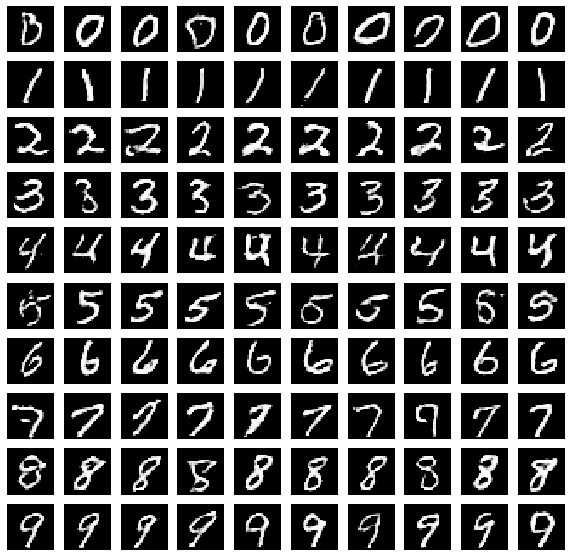

In [19]:
train(train_data_x, train_data_y, 10)

In [20]:
import shutil
shutil.make_archive('train_figs', 'zip', 'train_figs')

'/content/train_figs.zip'